# Tweeter Bot Detection

## Integrating machine learning to detect bots

Over the past ten plus years, Twitter has explosively evolved into a major communication hub. "Its primary purpose is to connect people and allow people to share their thoughts with a big audience. Twitter can also be a very helpful platform for growing a following and providing your audience with valuable content before they even become customers" [Hubspot](https://blog.hubspot.com/marketing/what-is-twitter). However, not all accounts are geninue users. According to a Twitter SEC filling in 2017, Twitter estimated 8.5% of all users to be bots. To validate the credibility of communication exchanged on the platform, efforts in idnetifying spam bots will help improve user's experience on twitter. 

In this project, we will be using [Cresci-2017](https://botometer.iuni.iu.edu/bot-repository/datasets.html) bot repository datasets to detect bot accounts. We'll begin with exploring traits between geniuine and bot accounts. Then, we will imploy supervised learning models (Logistic Regression, Random Forest, Stoachtic Gradient Boosting) to create a Twitter classifer. Finally, we'll use clustering to identify traits among geniue and spam bot accounts. 

 
### Overview of Data
There are a total of 5 files: 
 * 1 example submission files 
 * 2 transaction files (test and train)
 * 2 identity files (test and train) 
 
 We will be merging train transaction and train identity to gain more information regarding detecting fraud. To keep things simple, we will only be using the training sets. Below is a [description](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203) of the attributes in each table. 
 
__Transaction Table__

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
- Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

__Identity Table__

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38


In [1]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics tools
import scipy.stats as stats

# Sklearn data clean
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Logistic Regression
from sklearn.linear_model import Lasso, LogisticRegression

# KNN Classifer 
from sklearn.neighbors import KNeighborsClassifier

# Decision Trees
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
import pydotplus
import graphviz

# Random Forests 
from sklearn.ensemble import RandomForestClassifier

# SVM
from sklearn.svm import SVC

# Gradient Boost
from xgboost import XGBClassifier

# Evaluate
from sklearn import metrics
from sklearn.metrics import log_loss,accuracy_score, f1_score,roc_auc_score, confusion_matrix, classification_report

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Datetime
from datetime import datetime

# Import data
import warnings

In [2]:
# Import genuine accounts 
g_tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/genuine_accounts.csv/tweets.csv')

# Import spam bot accounts
soc_bot1_tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_1.csv/tweets.csv')
soc_bot2_tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_2.csv/tweets.csv')
soc_bot3_tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_3.csv/tweets.csv')


/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print('Genuine tweets')
print(g_tweets.shape)

print('---------------')

print('Spam bot tweets')
print(soc_bot1_tweets.shape)
print(soc_bot2_tweets.shape)
print(soc_bot3_tweets.shape)

Genuine tweets
(2839362, 25)
---------------
Spam bot tweets
(1610034, 25)
(428542, 25)
(1418557, 25)


## Merging datasets
The transaction training file lacks identity information on each transaction, so we will merge the training identity and transaction files on TransactionID. Since each observation has a unique transaction ID, we will do a 1 to 1 join. We will be performing a left join since our focus remains on the transaction table.

Below, we can see that the row length for train transaction and identity are not equal. It was noted that Vesta was unable to obtain all identity information so we will continue with the merge table for now.

In [4]:
b_tweets = pd.concat([soc_bot1_tweets,soc_bot2_tweets,soc_bot3_tweets], ignore_index=True, sort=False)

In [5]:
# Create tweet class, 1 for bot and 0 for genuine tweets
b_tweets['class'] = 1
g_tweets['class'] = 0

In [6]:
# Concatenate df
df = pd.concat([b_tweets,g_tweets], ignore_index=True, sort=False)

# Randomly shuffle df 
df = df.reindex(np.random.permutation(df.index))

In [7]:
df.head()

,id,text,source,user_id,truncated,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,retweeted_status_id,geo,...,retweeted,possibly_sensitive,num_hashtags,num_urls,num_mentions,created_at,timestamp,crawled_at,updated,class
3383648,525846251137290240,Read the History of Andy Kim http://t.co/08gx...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",1.162982e+09,NaN,0.000000e+00,0.000000e+00,NaN,0.0,NaN,...,NaN,NaN,0.0,1.0,0.0,Sat Oct 25 03:08:10 +0000 2014,2014-10-25 05:08:10,2014-11-13 06:29:44,2014-11-13 06:29:44,1
5418531,547005584940494848,Black Government,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",5.733002e+08,NaN,0.000000e+00,0.000000e+00,NaN,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,Mon Dec 22 12:27:48 +0000 2014,2014-12-22 13:27:48,2015-05-01 14:45:00,2015-05-01 14:45:00,0
3915614,589656889316671488,@metamorfourtris @GreyvityHoran IDK BUT I NEED...,"<a href=""http://twitter.com/download/android"" ...",1.735191e+09,NaN,5.896565e+17,2.335017e+09,metamorfourtris,0.0,NaN,...,NaN,NaN,0.0,0.0,2.0,Sun Apr 19 05:08:52 +0000 2015,2015-04-19 07:08:52,2015-05-01 13:16:58,2015-05-01 13:16:58,0
6150129,184503455312920576,@ashleygreenwood stop judging me....,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2.652811e+07,NaN,1.845025e+17,1.824430e+07,ashleygreenwood,0.0,NaN,...,NaN,NaN,0.0,0.0,1.0,Tue Mar 27 04:53:46 +0000 2012,2012-03-27 06:53:46,2015-05-01 16:08:36,2015-05-01 16:08:36,0
1715649,484499179029278722,Lol damn they got be sleeping in the Cold in t...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2.352150e+09,NaN,0.000000e+00,0.000000e+00,NaN,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,Thu Jul 03 00:49:40 +0000 2014,2014-07-03 02:49:40,2014-11-13 02:07:04,2014-11-13 02:07:04,1


In [8]:
df.shape

(6296495, 26)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6296495 entries, 3383648 to 1627889
Data columns (total 26 columns):
id                         object
text                       object
source                     object
user_id                    float64
truncated                  float64
in_reply_to_status_id      float64
in_reply_to_user_id        float64
in_reply_to_screen_name    object
retweeted_status_id        float64
geo                        float64
place                      object
contributors               float64
retweet_count              float64
reply_count                float64
favorite_count             float64
favorited                  float64
retweeted                  float64
possibly_sensitive         float64
num_hashtags               float64
num_urls                   float64
num_mentions               float64
created_at                 object
timestamp                  object
crawled_at                 object
updated                    object
class          

## Missing Values
Now, we will take a look at missing values in each column.

In [10]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [11]:
missing_values_table(df)

Your selected dataframe has 26 columns.
There are 24 columns that have missing values.


,Missing Values,% of Total Values
truncated,6296495,100.0
geo,6296495,100.0
contributors,6296495,100.0
favorited,6296495,100.0
retweeted,6296495,100.0
possibly_sensitive,6270292,99.6
place,6169527,98.0
in_reply_to_screen_name,5295806,84.1
text,12987,0.2
source,73,0.0


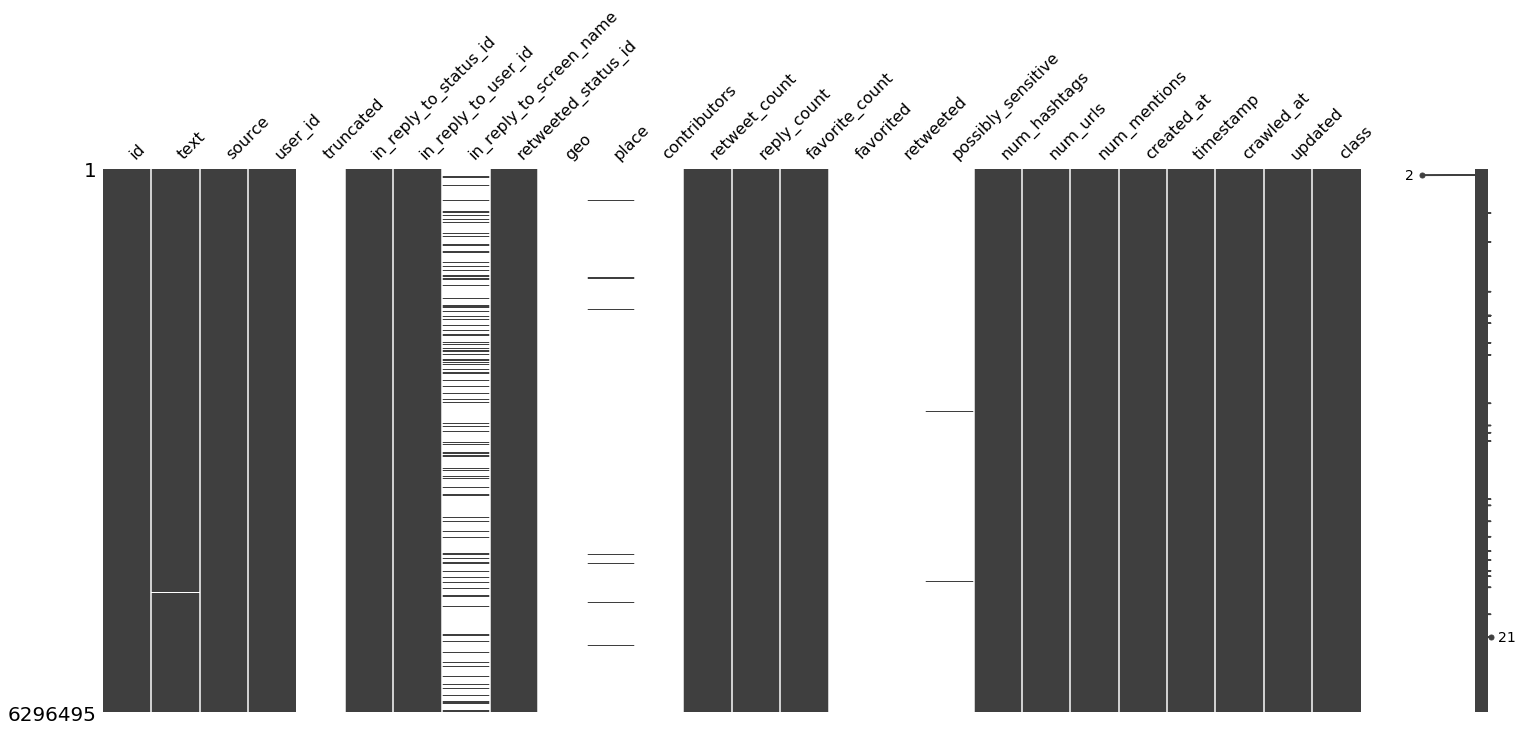

In [12]:
msno.matrix(df)

As shown in the matrix, many columns such as truncated, geo, contributors, etc. appear to be missing all datapoints. The data doesn't appear to be missing at random since there is a repetitive pattern between those columns. 

We will drop columns missing more than 90% of data points and in_reply_to_screen_name since that isn't our focus. Then, we will drop the remaining rows with missing values since that is only a small percentage of the dataset.

In [13]:
# Get columns with >= 80% missing
missing_df = missing_values_table(df)
missing_columns = list(missing_df[missing_df['% of Total Values'] >= 90].index)
print('We will drop %d columns.' % len(missing_columns))
print('Drop columns: ', missing_columns)

Your selected dataframe has 26 columns.
There are 24 columns that have missing values.
We will drop 7 columns.
Drop columns:  ['truncated', 'geo', 'contributors', 'favorited', 'retweeted', 'possibly_sensitive', 'place']


In [14]:
df.drop(labels=['truncated', 'geo', 'contributors', 'favorited', 'retweeted', 'possibly_sensitive', 'place','in_reply_to_screen_name'], axis=1, inplace=True)

In [15]:
# Drop all rows that have any NaN values
df.dropna()

,id,text,source,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,timestamp,crawled_at,updated,class
3383648,525846251137290240,Read the History of Andy Kim http://t.co/08gx...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",1.162982e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0.0,Sat Oct 25 03:08:10 +0000 2014,2014-10-25 05:08:10,2014-11-13 06:29:44,2014-11-13 06:29:44,1
5418531,547005584940494848,Black Government,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",5.733002e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,Mon Dec 22 12:27:48 +0000 2014,2014-12-22 13:27:48,2015-05-01 14:45:00,2015-05-01 14:45:00,0
3915614,589656889316671488,@metamorfourtris @GreyvityHoran IDK BUT I NEED...,"<a href=""http://twitter.com/download/android"" ...",1.735191e+09,5.896565e+17,2.335017e+09,0.000000e+00,0.0,0.0,0.0,0.0,0.0,2.0,Sun Apr 19 05:08:52 +0000 2015,2015-04-19 07:08:52,2015-05-01 13:16:58,2015-05-01 13:16:58,0
6150129,184503455312920576,@ashleygreenwood stop judging me....,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2.652811e+07,1.845025e+17,1.824430e+07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.0,Tue Mar 27 04:53:46 +0000 2012,2012-03-27 06:53:46,2015-05-01 16:08:36,2015-05-01 16:08:36,0
1715649,484499179029278722,Lol damn they got be sleeping in the Cold in t...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2.352150e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,Thu Jul 03 00:49:40 +0000 2014,2014-07-03 02:49:40,2014-11-13 02:07:04,2014-11-13 02:07:04,1
4825081,366404092798570496,If you have you pick then I can easily make yo...,"<a href=""http://twitter.com/download/android"" ...",1.869783e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,Sun Aug 11 03:41:57 +0000 2013,2013-08-11 05:41:57,2015-05-01 13:50:00,2015-05-01 13:50:00,0
1173064,528500095311163392,Ci sono attimi così attimi che se non stai att...,"<a href=""http://www.politico140.com"" rel=""nofo...",5.707268e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,Sat Nov 01 10:53:36 +0000 2014,2014-11-01 11:53:36,2014-11-13 13:09:51,2014-11-13 13:09:51,1
5418034,583524012971536384,@irene_cecelia @Blanksurface,"<a href=""http://twitter.com/download/iphone"" r...",2.251504e+09,5.835239e+17,2.170936e+09,0.000000e+00,0.0,0.0,1.0,0.0,0.0,2.0,Thu Apr 02 06:59:00 +0000 2015,2015-04-02 08:59:00,2015-05-01 14:44:52,2015-05-01 14:44:52,0
135358,528198153334702080,"""Dobbiamo solo rassegnarci al fatto che se non...","<a href=""http://www.aminamilanesi.it"" rel=""nof...",4.653655e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,1.0,0.0,0.0,0.0,Fri Oct 31 14:53:47 +0000 2014,2014-10-31 15:53:47,2014-11-13 05:55:20,2014-11-13 05:55:20,1
5891651,544688763277168641,RT @camerondallas: Okay! RT this or Tweet #Ex...,"<a href=""http://twitter.com/download/android"" ...",2.294724e+09,0.000000e+00,0.000000e+00,5.446882e+17,21204.0,0.0,0.0,1.0,0.0,1.0,Tue Dec 16 03:01:35 +0000 2014,2014-12-16 04:01:35,2015-05-01 15:58:17,2015-05-01 15:58:17,0


In [16]:
missing_values_table(df)

Your selected dataframe has 18 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
text,12987,0.2
source,73,0.0
user_id,1,0.0
in_reply_to_status_id,1,0.0
in_reply_to_user_id,1,0.0
retweeted_status_id,1,0.0
retweet_count,1,0.0
reply_count,1,0.0
favorite_count,1,0.0
num_hashtags,1,0.0


## Creating Time Series 

Time series data is used when we want to analyze or explore variation over time. This is useful when exploring Twitter text data if we want to track the prevalence of a word or set of words.

Let's convert timestamp into time datatype. 

In [17]:
# Print created_at to see the original format of datetime in Twitter data
print(df['created_at'].head())

3383648    Sat Oct 25 03:08:10 +0000 2014
5418531    Mon Dec 22 12:27:48 +0000 2014
3915614    Sun Apr 19 05:08:52 +0000 2015
6150129    Tue Mar 27 04:53:46 +0000 2012
1715649    Thu Jul 03 00:49:40 +0000 2014
Name: created_at, dtype: object


In [18]:
# Convert the created_at column to np.datetime object
df['created_at'] = pd.to_datetime(df['created_at'])

In [19]:
# Print created_at to see new format
print(df['created_at'].head())

3383648   2014-10-25 03:08:10+00:00
5418531   2014-12-22 12:27:48+00:00
3915614   2015-04-19 05:08:52+00:00
6150129   2012-03-27 04:53:46+00:00
1715649   2014-07-03 00:49:40+00:00
Name: created_at, dtype: datetime64[ns, UTC]


In [20]:
# Set the index of df to created_at
df = df.set_index('created_at')

In [21]:
df.describe()

,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,class
count,6.296494e+06,6.296494e+06,6.296494e+06,6.296494e+06,6.296494e+06,6296494.0,6.296494e+06,6.296494e+06,6.296494e+06,6.296494e+06,6.296495e+06
mean,7.419788e+08,7.363991e+16,1.156120e+08,6.558915e+16,3.839839e+02,0.0,5.439821e-01,1.540372e-01,1.892753e-01,3.935304e-01,5.490567e-01
std,7.567947e+08,1.823687e+17,4.381417e+08,1.753250e+17,1.124597e+04,0.0,4.658610e+00,5.909738e-01,3.970328e-01,7.259238e-01,4.975877e-01
min,6.780330e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.167643e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.858734e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,6.143131e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,2.525273e+09,5.941393e+17,3.224944e+09,5.941401e+17,3.350111e+06,0.0,4.278000e+03,2.800000e+01,6.000000e+00,1.900000e+01,1.000000e+00


In [ ]:
df.describe(include='all')

## Exploratory Data Analysis
Exploratory Data Analysis (EDA) is an iterative process to explore the data and summarize characteristics by calculating statistics or visualize methods. The purpose of EDA is gain an understanding of the data by identifying trends, anomalies, or relationships that might be helpful when making decisions in the modeling process.

In [ ]:
# Bot vs human tweets 
counts = df['class'].value_counts()
human = counts[0]
bot = counts[1]
human_per = (human/(human + bot))*100
bot_per = (bot/(human + bot))*100
print('There are {} tweets made by humans({:.3f}%) and {} tweets made by bots ({:.3f}%) in this dataset.'.format(human, human_per, bot, bot_per))

In [ ]:
# Plot target variable
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'class', data = df)
g.set_title('Count of Tweets made by Humans vs Bots', fontsize = 17)
g.set_xlabel('User Type', fontsize = 15)
g.set_ylabel('Tweets', fontsize = 15)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(df) * 100),
            ha="center", fontsize=15) 

In [ ]:
account = df.groupby(by='user_id', as_index=False).agg({'class':pd.Series.nunique})
account.describe()



In [ ]:
# tweets per day

In [ ]:
# tweet over time 

In [ ]:
# pauses between tweets

## Cleaning tweets

[Source](https://datascienceplus.com/twitter-analysis-with-python/)
You can see that in the first tweet we can find an URL, punctuations and a username of one tweetos (preceded by @). Before the data visualisation or the sentiment analysis it is necessary to clean the data. Delete the punctuations, the URLs, put the test in a lower case, extract the username for examples. It is possible to add more steps but in our case it won’t be useful.

For the first step we are going to extract the username through the tweets (preceded by @ or by RT @). We keep this information in the column “tweetos”.

In [ ]:
# Preprocessing del RT @blablabla:
df['tweetos'] = '' 

#add tweetos first part
for i in range(len(df['text'])):
    try:
        df['tweetos'][i] = df['text'].str.split(' ')[i][0]
    except AttributeError:    
        df['tweetos'][i] = 'other'

#Preprocessing tweetos. select tweetos contains 'RT @'
for i in range(len(df['text'])):
    if df['tweetos'].str.contains('@')[i]  == False:
        df['tweetos'][i] = 'other'
        
# remove URLs, RTs, and twitter handles
for i in range(len(df['text'])):
    df['text'][i] = " ".join([word for word in df['text'][i].split()
                                if 'http' not in word and '@' not in word and '<' not in word])


df['text'][1]

We can see that the first step of the cleaning it well done ! The username and the URL are deleted correctly. Now we are going to delete certains punctuations, put the text in lower case and delete the double space with the function apply.

In [ ]:
df['text'] = df['text'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
df['text'] = df['text'].apply(lambda x: re.sub('  ', ' ', x))
df['text'][1]

In [ ]:
# Save clean data into CSV
df.to_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/clean_df', header=True, index=False)

In [ ]:
tweets = df["text"]
def is_nan(x):
    return (x is np.nan or x != x)
ref_twts = []
indices_to_be_deleted = []
for j in range(0, tweets.shape[0]):
    if(not is_nan(tweets[j])):
        x = tweets[j].split(' ')
        str = ""
        #removing urls and user references from tweets
        for i in x:
            url1 = "https:"
            url2 = "http:"
            mentions= "@"
            
            if (url1 in i) or (url2 in i) or (mentions in i) or (len(i) == i.isdigit()):
                continue
            else:
                valids =""
                # to retain just letter in the string     
                for character in i:
                    if character.isalpha():
                        valids += character
                str= str+ " " + valids
        ref_twts.append(str)
    else:
        indices_to_be_deleted.append(j)

In [ ]:
len(ref_twts)

In [ ]:
len(indices_to_be_deleted)

In [ ]:
# steps to remove empty tweets
ref_twts = pd.DataFrame(ref_twts)
# getting indices of empty tweets
empty_tweet_indices = ref_twts[ref_twts[0] == ''].index
ref_twts = pd.DataFrame(ref_twts)
desired_indices = [i for i in range(0,ref_twts.shape[0]) if i not in empty_tweet_indices]
desired_ref_twts = ref_twts.iloc[desired_indices]

# convert dataframe to np array
desired_ref_twts = desired_ref_twts.values

# convert np array to one deminsional array 
desired_ref_twts = desired_ref_twts.ravel()

In [ ]:
# Text preprocessing, tokenizing and filtering of stopwords are all included 
# in CountVectorizer, which builds a dictionary of features and transforms 
# documents to feature vectors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(desired_ref_twts)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X)
X_tfidf_train_tf = tf_transformer.transform(X)
X_tfidf_train_tf.shape

In [ ]:
ref_twts.shape

In [ ]:
X_tfidf_train_tf.shape

In [ ]:
unwanted_indices = indices_to_be_deleted
desired_indices = [i for i in range(0,len(df)) if i not in unwanted_indices]
desired_rows = stweet_ds1_full[df.index.isin(desired_indices)]